## Fetch pool snapshots from balancer subgraph

In [9]:
from collections import defaultdict
import json
from datetime import datetime
from datetime import timedelta
from typing import Dict
from typing import List
from typing import Optional

from gql import Client
from gql import gql
from gql.transport.requests import RequestsHTTPTransport

from notebooks import get_block_by_ts
from notebooks.airdrop_arb_distribution.constants import BALANCER_GRAPH_URL
from notebooks.airdrop_arb_distribution.constants import POOLS_SNAPSHOTS_QUERY

# End date from timestamp
end_date = datetime.fromtimestamp(1701302400)
start_date = end_date - timedelta(days=14)
start_ts = int(start_date.timestamp())
end_ts = int(end_date.timestamp())

# Calculate end date approx block height
target_block = get_block_by_ts(end_ts, chain="mainnet")


# Fetch all the data from the balancer subgraph
def make_gql_client(url: str) -> Optional[Client]:
    transport = RequestsHTTPTransport(url=url, retries=3)
    return Client(
        transport=transport, fetch_schema_from_transport=True, execute_timeout=60
    )


def get_balancer_pool_snapshots() -> Optional[List[Dict]]:
    client = make_gql_client(BALANCER_GRAPH_URL)
    all_snapthots = []
    limit = 100
    offset = 0
    while True:
        result = client.execute(
            gql(POOLS_SNAPSHOTS_QUERY.format(first=limit, skip=offset, start_ts=start_ts, end_ts=end_ts)))
        all_snapthots.extend(result['poolSnapshots'])
        offset += limit
        if len(result['poolSnapshots']) < limit - 1:
            break
    # Need to group by pool address, since there are multiple snapshots per pool and we need to calculate 
    # difference between first and last snapshot
    pools = defaultdict(list)
    for snapshot in all_snapthots:
        pools[snapshot['pool']['address']].append(snapshot.get('protocolFee', 0))
    # Now calculate the difference between first and last snapshot
    fees_snapshots = []
    for pool_addr, snapshots in pools.items():
        if len(snapshots) > 1:
            # Convert to int with respect that there might be null values and string values
            first_snapshot = float(snapshots[0]) if snapshots[0] else 0
            last_snapshot = float(snapshots[-1]) if snapshots[-1] else 0
            fee_collected = first_snapshot - last_snapshot
            assert fee_collected >= 0, f"Fee collected for pool {pool_addr} is negative"
            fees_snapshots.append({
                'pool': {
                    'address': pool_addr,
                },
                'protocolFee': fee_collected
            })
    return fees_snapshots


pool_snapshots = get_balancer_pool_snapshots()
print(f"Collected data for dates: {start_date.date()} - {end_date.date()}")
print(f"Block height at the end date: {target_block}")

Collected data for dates: 2023-11-16 - 2023-11-30
Block height at the end date: 18680865


## Calculate BAL emissions per week:

In [10]:
from notebooks.arb_dao_grant_distribution.emissions_per_year import EMISSIONS_PER_YEAR
from notebooks.arb_dao_grant_distribution.constants import CURRENT_YEAR

emissions_per_week = 0
for item in EMISSIONS_PER_YEAR['data']:
    if item['year'] == str(CURRENT_YEAR):
        emissions_per_week = float(item['balPerWeek'])
        break
print(f'Current BAL emissions per week: {emissions_per_week}')

Current BAL emissions per week: 121929.98021178861


## Pre-process all the data in this cell

In [11]:
from notebooks import fetch_all_pools_info
from notebooks.arb_dao_grant_distribution.static_boosts import STATIC_BOOST
from notebooks.arb_dao_grant_distribution.constants import BALANCER_GAUGE_CONTROLLER_ABI
from notebooks.arb_dao_grant_distribution.constants import BALANCER_GAUGE_CONTROLLER_ADDR
import os

from dotenv import load_dotenv
from web3 import Web3
from pycoingecko import CoinGeckoAPI

load_dotenv()
ARBITRUM_CHAIN_LITERAL = "ARBITRUM"
web3 = Web3(Web3.HTTPProvider(os.environ["ETHNODEURL"]))

# fetch balancer token usd price:
cg = CoinGeckoAPI()
bal_token_price = cg.get_price(ids='balancer', vs_currencies='usd')['balancer']['usd']
# Fetch all pools from Balancer API
all_pools = fetch_all_pools_info("arbitrum")

# Collect arb gauges
arb_gauges = {}
for pool in all_pools:
    # Only collect gauges for the arb chain and that are not killed
    if pool['chain'] == ARBITRUM_CHAIN_LITERAL and pool['gauge']['isKilled'] is False:
        _gauge_addr = Web3.to_checksum_address(pool['gauge']['address'])
        arb_gauges[_gauge_addr] = {
            'gaugeAddress': pool['gauge']['address'],
            'poolAddress': pool['address'],
            'pool': pool['address'],
            'symbol': pool['symbol'],
            'id': pool['id'],
        }

gauge_c_contract = web3.eth.contract(address=BALANCER_GAUGE_CONTROLLER_ADDR, abi=BALANCER_GAUGE_CONTROLLER_ABI)

boost_data = {}
cap_override_data = {}
# Load static boost here
for boost in STATIC_BOOST:
    _gauge_addr = Web3.to_checksum_address(boost['gaugeAddress'])
    boost_data[_gauge_addr] = boost.get('fixedBoost', 1)
    cap_override_data[_gauge_addr] = boost.get('capOverride', 10)
pool_protocol_fees = {}

# Collect protocol fees from the pool snapshots:
for gauge_addr, gauge_data in arb_gauges.items():
    for pool_snapshot in pool_snapshots:
        if Web3.to_checksum_address(pool_snapshot['pool']['address']) == Web3.to_checksum_address(gauge_data['pool']):
            # Since snapshots are sorted by timestamp descending, we can just take the first one we find for each pool and break
            protocol_fee = float(pool_snapshot['protocolFee']) if pool_snapshot['protocolFee'] else 0
            pool_protocol_fees[Web3.to_checksum_address(gauge_addr)] = protocol_fee
            break

In [12]:
# Apply boost data to arb gauges
vote_weights = {}
combined_boost = {}
# Dynamic boost data to print out in the final table
dynamic_boosts = {}
# Collect gauge voting weights from the gauge controller on chain
for gauge_addr, gauge_data in arb_gauges.items():
    weight = gauge_c_contract.functions.gauge_relative_weight(Web3.to_checksum_address(gauge_addr)).call(
        block_identifier=target_block) / 1e18 * 100
    arb_gauges[gauge_addr]['weightNoBoost'] = weight
    # Calculate dynamic boost. Formula is `[Fees earned/value of bal emitted per pool + 1]`
    dollar_value_of_bal_emitted = (weight / 100) * emissions_per_week * bal_token_price
    if dollar_value_of_bal_emitted != 0:
        dynamic_boost = (pool_protocol_fees.get(gauge_addr, 0) / dollar_value_of_bal_emitted) + 1
    else:
        dynamic_boost = 1
    dynamic_boosts[gauge_addr] = dynamic_boost
    # Now calculate the final boost value, which uses formula - (dynamic boost + fixed boost) - 1
    boost = (dynamic_boost + boost_data.get(gauge_addr, 1)) - 1
    combined_boost[gauge_addr] = boost
    weight *= boost
    vote_weights[gauge_addr] = weight
    arb_gauges[gauge_addr]['voteWeight'] = weight

KEK
KEK


## Calculate arbitrum distribution across gauges

In [13]:
from notebooks.arb_dao_grant_distribution.constants import ARBITRUM_TOTAL
from notebooks.arb_dao_grant_distribution.constants import ARBITRUM_BONUS
from notebooks.arb_dao_grant_distribution.constants import GAUGES_WITH_BONUSES
from notebooks.arb_dao_grant_distribution.constants import VOTE_CAP_IN_PERCENT
from notebooks.arb_dao_grant_distribution.constants import ARBITRUM_TO_DISTRIBUTE
from notebooks import get_abi
from IPython.core.display import HTML
import pandas as pd

# Vote caps in percents are calculated as a percentage of the total amount of arb to distribute
VOTE_CAPS_IN_PERCENTS = {gauge_addr: cap_override_data.get(gauge_addr, VOTE_CAP_IN_PERCENT) for gauge_addr in
                         arb_gauges.keys()}
# Custom gauge caps taken from boost data, calculated as a percentage of the total amount of arb to distribute
VOTE_CAPS = {gauge_addr: VOTE_CAPS_IN_PERCENTS[gauge_addr] / 100 * ARBITRUM_TOTAL for gauge_addr in
             arb_gauges.keys()}

# Calculate total weight
total_weight = sum([gauge['voteWeight'] for gauge in arb_gauges.values()])
arb_gauge_distributions = {}
for gauge_addr, gauge_data in arb_gauges.items():
    gauge_addr = Web3.to_checksum_address(gauge_addr)
    # Calculate distribution based on vote weight and total weight
    to_distribute = ARBITRUM_TO_DISTRIBUTE * gauge_data['voteWeight'] / total_weight
    # Cap distribution
    to_distribute = to_distribute if to_distribute < VOTE_CAPS[gauge_addr] else VOTE_CAPS[gauge_addr]
    # Get arb gauge addr
    mainnet_arb_root_gauge_contract = web3.eth.contract(
        address=Web3.to_checksum_address(gauge_addr),
        abi=get_abi("ArbRootGauge")
    )
    arb_gauge_distributions[gauge_addr] = {
        'recipientGaugeAddr': mainnet_arb_root_gauge_contract.functions.getRecipient().call(),
        'poolAddress': gauge_data['poolAddress'],
        'symbol': gauge_data['symbol'],
        'voteWeight': gauge_data['voteWeight'],
        'voteWeightNoBoost': gauge_data['weightNoBoost'],
        'distribution': to_distribute if to_distribute < VOTE_CAPS[gauge_addr] else VOTE_CAPS[gauge_addr],
        'pctDistribution': to_distribute / ARBITRUM_TOTAL * 100,
        'boost': combined_boost.get(gauge_addr, 1),
        'staticBoost': boost_data.get(gauge_addr, 1),
        'dynamicBoost': dynamic_boosts.get(gauge_addr, 1),
        'cap': f"{cap_override_data.get(gauge_addr, VOTE_CAP_IN_PERCENT)}%",
        'bonus': 0
    }


# Spend unspent arb on the gauges that are not capped yet
def recur_distribute_unspend_arb():
    unspent_arb = ARBITRUM_TO_DISTRIBUTE - sum([gauge['distribution'] for gauge in arb_gauge_distributions.values()])
    if unspent_arb > 0:
        # Find out total voting weight of uncapped gauges and mark it as 100%:
        total_uncapped_weight = sum(
            [g['voteWeight'] for g in [
                gauge for addr, gauge in arb_gauge_distributions.items() if gauge['distribution'] < VOTE_CAPS[addr]]
             ]
        )
        # Iterate over uncapped gauges and distribute unspent arb proportionally to their voting weight which is total uncapped weight
        for a, uncap_gauge in {addr: gauge for addr, gauge in arb_gauge_distributions.items() if
                               gauge['distribution'] < VOTE_CAPS[addr]}.items():
            # For each loop calculate unspend arb
            unspent_arb = ARBITRUM_TO_DISTRIBUTE - sum(
                [gauge['distribution'] for gauge in arb_gauge_distributions.values()])
            # Don't distribute more than vote cap
            distribution = min(
                uncap_gauge['distribution'] + unspent_arb * uncap_gauge['voteWeight'] / total_uncapped_weight,
                VOTE_CAPS[a])
            uncap_gauge['distribution'] = distribution
            uncap_gauge['pctDistribution'] = uncap_gauge['distribution'] / ARBITRUM_TOTAL * 100
    # Call recursively if there is still unspent arb
    if ARBITRUM_TO_DISTRIBUTE - sum([g['distribution'] for g in arb_gauge_distributions.values()]) > 0:
        recur_distribute_unspend_arb()


recur_distribute_unspend_arb()

print(
    f"Unspent arb: {ARBITRUM_TO_DISTRIBUTE - sum([gauge['distribution'] for gauge in arb_gauge_distributions.values()])}")
print(f"Arb distributed: {sum([gauge['distribution'] for gauge in arb_gauge_distributions.values()])}")
# # Remove arb gauges with 0 distribution
arb_gauge_distributions = {addr: gauge for addr, gauge in arb_gauge_distributions.items() if
                           gauge['distribution'] > 0}
# Toss in bonus arb to the predefined gauge:
for gauge, gauge_info in GAUGES_WITH_BONUSES.items():
    # Calculate bonus per pool
    arbitrum_bonus_per_pool = ARBITRUM_BONUS / len(GAUGES_WITH_BONUSES)
    # If gauge already exists, add bonus to it and recalculate % distribution, if not - create new gauge with bonus
    if arb_gauge_distributions.get(gauge):
        arb_gauge_distributions[gauge]['distribution'] += arbitrum_bonus_per_pool
        arb_gauge_distributions[gauge]['pctDistribution'] = arb_gauge_distributions[gauge]['distribution'] / ARBITRUM_TOTAL * 100
        arb_gauge_distributions[gauge]['bonus'] = arbitrum_bonus_per_pool
    else:
        arb_gauge_distributions[gauge] = {
            'recipientGaugeAddr': gauge_info['recipientGauge'],
            'poolAddress': gauge_info['poolAddress'],
            'symbol': gauge_info['symbol'],
            'voteWeight': 0,
            'voteWeightNoBoost': 0,
            'distribution': arbitrum_bonus_per_pool,
            'pctDistribution': arbitrum_bonus_per_pool / ARBITRUM_TOTAL * 100,
            'boost': combined_boost.get(gauge, 1),
            'staticBoost': boost_data.get(gauge, 1),
            'dynamicBoost': dynamic_boosts.get(gauge, 1),
            'cap': f"{cap_override_data.get(gauge, VOTE_CAP_IN_PERCENT)}%",
            'bonus': arbitrum_bonus_per_pool
        }
arb_gauge_distributions_df = pd.DataFrame.from_dict(arb_gauge_distributions, orient='index')
arb_gauge_distributions_df = arb_gauge_distributions_df.sort_values(by='pctDistribution', ascending=False)
print(f"Total arb distributed incl bonus: {sum([gauge['distribution'] for gauge in arb_gauge_distributions.values()])}")
display(HTML(arb_gauge_distributions_df.to_html(index=False)))

Unspent arb: 0.0
Arb distributed: 183214.8
Total arb distributed incl bonus: 205714.8


recipientGaugeAddr,poolAddress,symbol,voteWeight,voteWeightNoBoost,distribution,pctDistribution,boost,staticBoost,dynamicBoost,cap,bonus
0xd6B875d62c2661eaB66472F36c672e4B512f1135,0xade4a71bb62bec25154cfc7e6ff49a513b491e81,rETH-WETH-BPT,2.506725,1.179890,25768.010829,12.526085,2.124542,1.75,1.374542,20%,0.0
0x2eB5661002b68EBE887d29d415c3A3b52536912C,0x4a2f6ae7f3e5d715689530873ec35593dc28951b,wstETH/rETH/cbETH,1.522699,0.502228,22596.390119,10.984329,3.031889,1.75,2.281889,20%,0.0
0xcf9f895296F5e1D66a7D4dcf1d92e1B435E9f999,0x32df62dc3aed2cd6224193052ce665dc18165841,RDNT-WETH,7.270623,1.486339,20571.480000,10.000000,4.891631,1.50,4.391631,10%,0.0
0xd956246EA5b06DEa930F0A7feC1FFf000436e3f2,0x8bc65eed474d1a00555825c91feab6a8255c2107,DOLA/USDC BPT,1.510452,1.502420,19188.008560,9.327481,1.005346,1.00,1.005346,10%,0.0
0xcF853F14EF6111435Cb39c0C43C66366cc6300F1,0x2e8ea681fd59c9dc5f32b29de31f782724ef4dcb,50GOLD-25USDC-25WSTETH,6.271740,5.981859,16457.184000,8.000000,1.048460,1.00,1.048460,8%,0.0
0xfC745035F31BCbaEb2D1a89aA9171495c671F6cE,0x3fd4954a851ead144c2ff72b1f5a38ea5976bd54,ankrETH/wstETH-BPT,1.262526,0.483117,13523.403866,6.573860,2.613292,1.75,1.863292,20%,0.0
0xeF767E740D83d410794519c2F93Db32e44359a5C,0xb3028ca124b80cfe6e9ca57b70ef2f0ccc41ebd4,50MAGIC-50USDC,0.864870,0.376813,11922.831189,5.795806,2.295223,1.00,2.295223,10%,0.0
0xa14453084318277b11d38FbE05D857A4f647442B,0x423a1323c871abc9d89eb06855bf5347048fc4a5,4POOL-BPT,0.000000,0.000000,11250.000000,5.468736,1.000000,1.00,1.000000,10%,11250.0
0x138E37c3885169DB38e046D5c814C0e95566566c,0xa1a8bf131571a2139feb79401aa4a2e9482df627,wstETH-4POOL,0.000000,0.000000,11250.000000,5.468736,1.000000,1.00,1.000000,10%,11250.0
0x972539E9d340a915775C004715f286a166F067Fd,0x85ec6ae01624ae0d2a04d0ffaad3a25884c7d0f3,80OVN/20wUSD+,0.725690,0.719809,9505.252224,4.620597,1.008171,1.00,1.008171,10%,0.0


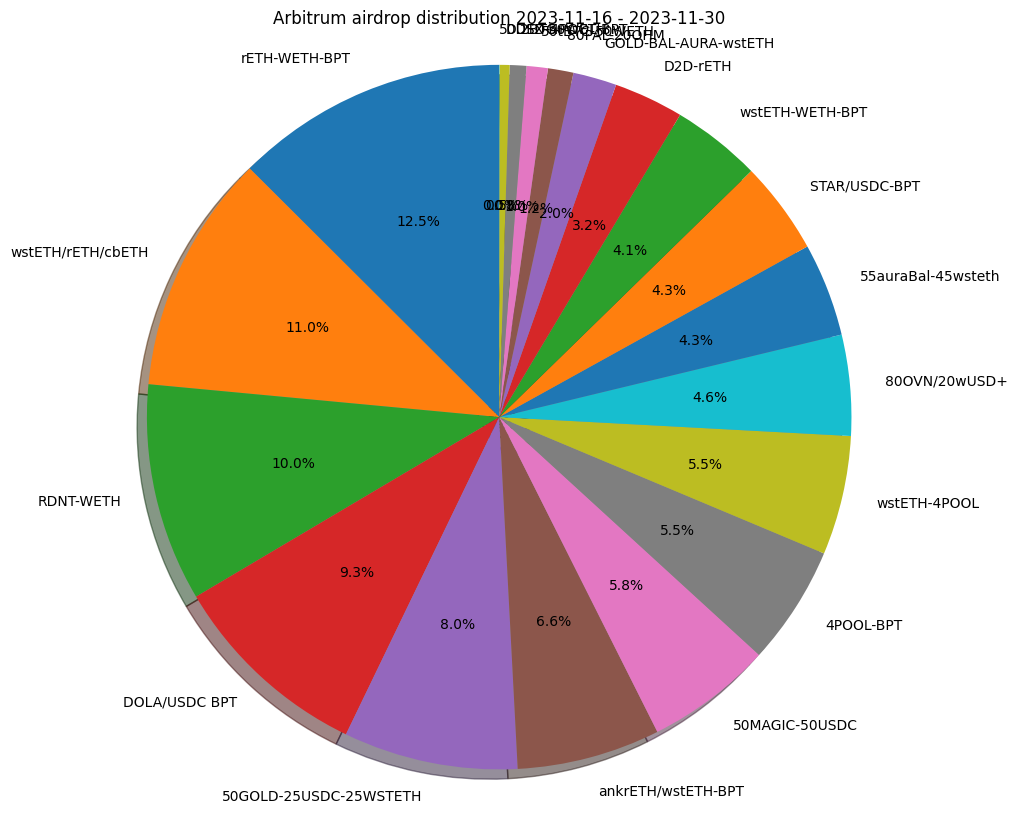

In [14]:
# Display pie chart of distribution
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = arb_gauge_distributions_df['symbol']
sizes = arb_gauge_distributions_df['pctDistribution']
explode = [0.1 if label == 'ARB/USD' else 0 for label in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Increase chart size to 10x10
fig1.set_size_inches(10, 10)
ax1.set_title(f'Arbitrum airdrop distribution {start_date.date()} - {end_date.date()}')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Export to json

In [15]:
from decimal import Decimal

# Export to csv
arb_gauge_distributions_df.to_csv(f'./output/dao_grant_{start_date.date()}_{end_date.date()}.csv',
                                  index=False)

# Dump into output.json using:
with open('../../data/output_tx_template.json') as f:
    output_data = json.load(f)

# Find transaction with func name `setRecipientList` and dump gauge 
gauge_distributions = arb_gauge_distributions.values()
for tx in output_data['transactions']:
    if tx['contractMethod']['name'] == 'setRecipientList':
        # Inject list of gauges addresses:
        tx['contractInputsValues'][
            'gaugeAddresses'] = f"[{','.join([gauge['recipientGaugeAddr'] for gauge in gauge_distributions])}]"
        # Inject vote weights:
        # Dividing by 2 since we are distributing for 2 weeks and 1 week is a period
        tx['contractInputsValues'][
            'amountsPerPeriod'] = f"[{','.join([str(int(Decimal(gauge['distribution']) * Decimal(1e18) / 2)) for gauge in gauge_distributions])}]"
        tx['contractInputsValues']['maxPeriods'] = f"[{','.join(['2' for gauge in gauge_distributions])}]"
    if tx['contractMethod']['name'] == 'transfer':
        tx['contractInputsValues']['amount'] = str(int(Decimal(ARBITRUM_TOTAL) * Decimal(1e18)))

# Dump back to arb_distribution_for_msig.json
with open(f'./output/dao_grant_{start_date.date()}_{end_date.date()}.json', 'w') as f:
    json.dump(output_data, f, indent=4)